# Convolutional VAE

### Nikodem Matuszkiewicz

## Imports and preprocessing

In [2]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.4 MB/s eta 0:00:00


In [3]:
from facenet_pytorch import MTCNN
import torch
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.transforms.functional import rgb_to_grayscale, equalize
from torchvision.transforms.functional import resize, crop
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam, AdamW, SGD
import torchvision.transforms.functional as vision_functional
from torch.nn.functional import pad
from torchvision.utils import make_grid
from IPython.display import display
from PIL import Image
import math

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/lfw.zip lfw.zip
!unzip lfw.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: lfw/Andre_Agassi/Andre_Agassi_0017.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0018.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0019.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0020.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0021.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0022.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0023.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0024.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0025.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0026.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0027.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0028.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0029.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0030.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0031.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0032.jpg  
  inflating: lfw/Andre_Agassi/Andre_Agassi_0033.jpg  
  inflating: lfw/

In [5]:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

def preprocess_images(images_dir, output_images_dir):
    if not os.path.exists(output_images_dir):
        os.mkdir(output_images_dir)
    rejected = 0
    data = []
    data_paths_all_out = []
    data_paths_all = []
    subdirectories = os.listdir(images_dir)
    for sd in subdirectories:
        d = os.path.join(images_dir,sd)
        image_paths = os.listdir(d)
        for image_path in image_paths:
            data_paths_all_out.append(os.path.join(output_images_dir, image_path))
            data_paths_all.append(os.path.join(d, image_path))
            
    weights_segmentation = DeepLabV3_ResNet101_Weights.DEFAULT
    model_segmentation = deeplabv3_resnet101(weights_segmentation).cuda()
    model_segmentation.eval()
    preprocess_segmentation = weights_segmentation.transforms()
    class_to_idx_segmentation = {cls: idx for (idx, cls) in enumerate(weights_segmentation.meta["categories"])}

    mtcnn = MTCNN(select_largest=False, post_process=False, device='cuda:0', margin=25)
    pil_transform = ToPILImage()
    
    for i in range(len(data_paths_all)):
        img_path = data_paths_all[i]
        img_path_out = data_paths_all_out[i]
        if not os.path.exists(img_path_out):
            with Image.open(img_path) as img:
                face = mtcnn(img).cuda() / 255
                img = resize(face, (64, 64))

                segmentation_batch = preprocess_segmentation(img).unsqueeze(0)
                segmentation_prediction = model_segmentation(segmentation_batch)["out"]
                segmentation_normalized_masks = segmentation_prediction.softmax(dim=1)
                segmentation_mask = segmentation_normalized_masks[0, class_to_idx_segmentation["person"]]
                segmentation_mask = segmentation_mask.detach().unsqueeze(0)
                segmentation_mask = resize(segmentation_mask, (64, 64))

                out = torch.where(segmentation_mask > 0.6, rgb_to_grayscale(img), torch.zeros_like(segmentation_mask))
                background_ratio = torch.where(out == 0, torch.ones_like(out), torch.zeros_like(out)).sum() / 4096
                if background_ratio < 0.3:
                    out = to_pil_image(out.cpu())
                    out.save(img_path_out)
    
preprocess_images("./lfw", "./lfw_preprocessed")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [6]:
class FacesDataset(Dataset):
    def __init__(self, images_dir):
        self.data = []
        images = os.listdir(images_dir)
        for img_path in images:
            img = read_image(os.path.join(images_dir,img_path), ImageReadMode.GRAY)
            self.data.append(equalize(img))
        self.data = torch.stack(self.data).type(torch.float32).cuda() / 255
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx, ...]
    

In [7]:
batch_size = 64
dataset = FacesDataset("./lfw_preprocessed")
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model definition

In [8]:
latent_size = 512
class Conv_VAE(nn.Module):
    def __init__(self, channels_in_img=1, latent_size=latent_size):
        super(Conv_VAE, self).__init__()
        
        self.semi_encoder = nn.Sequential(
            nn.BatchNorm2d(channels_in_img),
            
            nn.Conv2d(channels_in_img, 32, kernel_size=(3, 3)),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
            nn.LayerNorm((32, 62, 62)),
            
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, kernel_size=(5, 5)),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
            nn.LayerNorm((64, 27, 27)),
            
            nn.AvgPool2d(2),
            nn.Conv2d(64, 96, kernel_size=(3, 3)),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
            nn.LayerNorm((96, 11, 11)),
            
            nn.AvgPool2d(2),
            nn.Conv2d(96, 128, kernel_size=(3, 3)),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
            nn.LayerNorm((128, 3, 3)),
            
            nn.Flatten()
        )
        
        flat_size = 128*3*3
        
        self.enc_mean = nn.Linear(flat_size, latent_size)
        self.enc_logvar = nn.Linear(flat_size, latent_size)
        self.dec_linear = nn.Linear(latent_size, flat_size)
        
        self.semi_decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 96, kernel_size=(3, 3)),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
            nn.Upsample(scale_factor=2, mode="bicubic"),
            #nn.MaxUnpool2d(2),
            
            nn.ConvTranspose2d(96, 64, kernel_size=(5,5)),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
            nn.Upsample(scale_factor=2, mode="bicubic"),
            #nn.MaxUnpool2d(2),
            
            nn.ConvTranspose2d(64, 32, kernel_size=(4,4)),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
            nn.Upsample(scale_factor=2, mode="bicubic"),
            #nn.MaxUnpool2d(2),
            
            nn.ConvTranspose2d(32, channels_in_img, kernel_size=(3,3)),     
            nn.Sigmoid()
        )
        
    
    def reparam(self, mean, logvar):
        std = torch.exp(logvar * 0.5)
        epsilon = torch.randn_like(logvar)
        return mean + std * epsilon
    
    def forward(self, x):
        x = self.semi_encoder(x)
        mean = self.enc_mean(x)
        logvar = self.enc_logvar(x)
        z = self.reparam(mean, logvar)
        x = self.dec_linear(z)
        x = x.view((-1, 128, 3, 3))
        x = self.semi_decoder(x)
        return x, mean, logvar
    
    def generate(self, z):
        x = self.dec_linear(z)
        x = x.view((-1, 128, 3, 3))
        x = self.semi_decoder(x)
        return x
    
    

## Model training

[Epoch 1] Training Loss: 812.337           | KL l.: 44.472 | Rec l.: 767.864


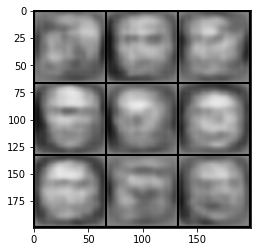

[Epoch 2] Training Loss: 683.107           | KL l.: 49.477 | Rec l.: 633.630
[Epoch 3] Training Loss: 657.806           | KL l.: 52.530 | Rec l.: 605.275
[Epoch 4] Training Loss: 645.429           | KL l.: 53.643 | Rec l.: 591.787
[Epoch 5] Training Loss: 638.055           | KL l.: 54.745 | Rec l.: 583.310
[Epoch 6] Training Loss: 630.382           | KL l.: 55.244 | Rec l.: 575.139
[Epoch 7] Training Loss: 624.923           | KL l.: 56.051 | Rec l.: 568.872
[Epoch 8] Training Loss: 620.847           | KL l.: 57.377 | Rec l.: 563.471
[Epoch 9] Training Loss: 616.604           | KL l.: 58.295 | Rec l.: 558.309
[Epoch 10] Training Loss: 612.760           | KL l.: 58.795 | Rec l.: 553.965
[Epoch 11] Training Loss: 608.215           | KL l.: 59.396 | Rec l.: 548.819
[Epoch 12] Training Loss: 602.957           | KL l.: 59.410 | Rec l.: 543.547
[Epoch 13] Training Loss: 599.240           | KL l.: 59.536 | Rec l.: 539.703
[Epoch 14] Training Loss: 595.878           | KL l.: 59.764 | Rec l.: 53

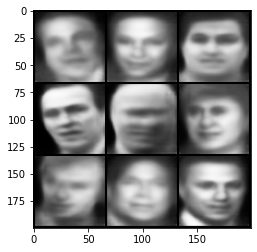

[Epoch 52] Training Loss: 528.873           | KL l.: 67.255 | Rec l.: 461.618
[Epoch 53] Training Loss: 527.881           | KL l.: 67.313 | Rec l.: 460.568
[Epoch 54] Training Loss: 526.856           | KL l.: 67.336 | Rec l.: 459.520
[Epoch 55] Training Loss: 526.705           | KL l.: 67.624 | Rec l.: 459.081
[Epoch 56] Training Loss: 526.073           | KL l.: 67.902 | Rec l.: 458.171
[Epoch 57] Training Loss: 526.064           | KL l.: 68.174 | Rec l.: 457.890
[Epoch 58] Training Loss: 525.381           | KL l.: 68.256 | Rec l.: 457.125
[Epoch 59] Training Loss: 524.896           | KL l.: 68.300 | Rec l.: 456.596
[Epoch 60] Training Loss: 524.440           | KL l.: 68.461 | Rec l.: 455.979
[Epoch 61] Training Loss: 523.802           | KL l.: 68.476 | Rec l.: 455.326
[Epoch 62] Training Loss: 522.943           | KL l.: 68.706 | Rec l.: 454.238
[Epoch 63] Training Loss: 522.422           | KL l.: 68.836 | Rec l.: 453.587
[Epoch 64] Training Loss: 522.166           | KL l.: 69.143 | Re

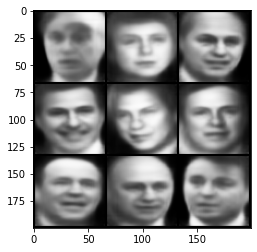

[Epoch 102] Training Loss: 506.501           | KL l.: 73.786 | Rec l.: 432.716
[Epoch 103] Training Loss: 506.385           | KL l.: 73.881 | Rec l.: 432.505
[Epoch 104] Training Loss: 505.999           | KL l.: 73.909 | Rec l.: 432.090
[Epoch 105] Training Loss: 505.835           | KL l.: 74.000 | Rec l.: 431.835
[Epoch 106] Training Loss: 505.676           | KL l.: 74.057 | Rec l.: 431.619
[Epoch 107] Training Loss: 505.322           | KL l.: 74.138 | Rec l.: 431.184
[Epoch 108] Training Loss: 505.231           | KL l.: 74.184 | Rec l.: 431.047
[Epoch 109] Training Loss: 505.030           | KL l.: 74.306 | Rec l.: 430.724
[Epoch 110] Training Loss: 504.564           | KL l.: 74.229 | Rec l.: 430.335
[Epoch 111] Training Loss: 504.728           | KL l.: 74.326 | Rec l.: 430.402
[Epoch 112] Training Loss: 504.204           | KL l.: 74.466 | Rec l.: 429.737
[Epoch 113] Training Loss: 504.279           | KL l.: 74.609 | Rec l.: 429.670
[Epoch 114] Training Loss: 503.770           | KL l.

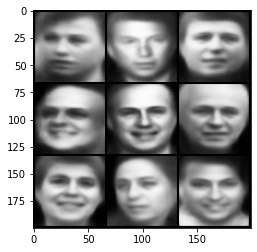

[Epoch 152] Training Loss: 496.810           | KL l.: 76.332 | Rec l.: 420.479
[Epoch 153] Training Loss: 497.116           | KL l.: 76.652 | Rec l.: 420.464
[Epoch 154] Training Loss: 496.896           | KL l.: 76.649 | Rec l.: 420.248
[Epoch 155] Training Loss: 496.495           | KL l.: 76.487 | Rec l.: 420.009
[Epoch 156] Training Loss: 496.713           | KL l.: 76.729 | Rec l.: 419.984
[Epoch 157] Training Loss: 496.458           | KL l.: 76.831 | Rec l.: 419.627
[Epoch 158] Training Loss: 496.295           | KL l.: 76.837 | Rec l.: 419.459
[Epoch 159] Training Loss: 495.915           | KL l.: 76.830 | Rec l.: 419.084
[Epoch 160] Training Loss: 495.899           | KL l.: 76.870 | Rec l.: 419.029
[Epoch 161] Training Loss: 495.938           | KL l.: 76.935 | Rec l.: 419.003
[Epoch 162] Training Loss: 495.712           | KL l.: 76.961 | Rec l.: 418.751
[Epoch 163] Training Loss: 495.778           | KL l.: 77.249 | Rec l.: 418.529
[Epoch 164] Training Loss: 495.354           | KL l.

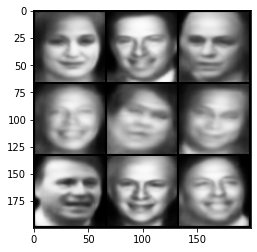

[Epoch 202] Training Loss: 490.967           | KL l.: 78.392 | Rec l.: 412.576
[Epoch 203] Training Loss: 490.777           | KL l.: 78.497 | Rec l.: 412.280
[Epoch 204] Training Loss: 490.552           | KL l.: 78.489 | Rec l.: 412.063
[Epoch 205] Training Loss: 490.595           | KL l.: 78.494 | Rec l.: 412.101
[Epoch 206] Training Loss: 490.671           | KL l.: 78.593 | Rec l.: 412.079
[Epoch 207] Training Loss: 490.146           | KL l.: 78.590 | Rec l.: 411.555
[Epoch 208] Training Loss: 490.292           | KL l.: 78.720 | Rec l.: 411.572
[Epoch 209] Training Loss: 490.043           | KL l.: 78.823 | Rec l.: 411.219
[Epoch 210] Training Loss: 489.965           | KL l.: 78.939 | Rec l.: 411.026
[Epoch 211] Training Loss: 489.829           | KL l.: 78.816 | Rec l.: 411.012
[Epoch 212] Training Loss: 489.667           | KL l.: 78.939 | Rec l.: 410.728
[Epoch 213] Training Loss: 489.590           | KL l.: 78.920 | Rec l.: 410.670
[Epoch 214] Training Loss: 489.663           | KL l.

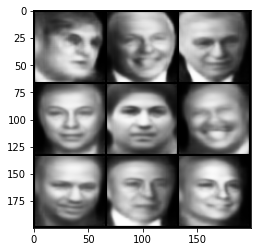

[Epoch 252] Training Loss: 486.213           | KL l.: 80.734 | Rec l.: 405.478
[Epoch 253] Training Loss: 486.288           | KL l.: 80.669 | Rec l.: 405.619
[Epoch 254] Training Loss: 485.654           | KL l.: 80.500 | Rec l.: 405.154
[Epoch 255] Training Loss: 485.778           | KL l.: 80.559 | Rec l.: 405.219
[Epoch 256] Training Loss: 485.721           | KL l.: 80.719 | Rec l.: 405.003
[Epoch 257] Training Loss: 485.808           | KL l.: 80.703 | Rec l.: 405.105
[Epoch 258] Training Loss: 485.503           | KL l.: 80.758 | Rec l.: 404.745
[Epoch 259] Training Loss: 485.737           | KL l.: 80.898 | Rec l.: 404.839
[Epoch 260] Training Loss: 485.237           | KL l.: 80.578 | Rec l.: 404.659
[Epoch 261] Training Loss: 485.275           | KL l.: 80.618 | Rec l.: 404.656
[Epoch 262] Training Loss: 485.419           | KL l.: 80.868 | Rec l.: 404.551
[Epoch 263] Training Loss: 485.300           | KL l.: 80.943 | Rec l.: 404.357
[Epoch 264] Training Loss: 485.428           | KL l.

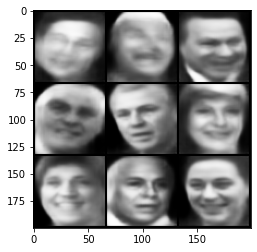

[Epoch 302] Training Loss: 482.911           | KL l.: 81.578 | Rec l.: 401.333
[Epoch 303] Training Loss: 482.742           | KL l.: 81.684 | Rec l.: 401.058
[Epoch 304] Training Loss: 482.600           | KL l.: 81.676 | Rec l.: 400.924
[Epoch 305] Training Loss: 482.299           | KL l.: 81.494 | Rec l.: 400.805
[Epoch 306] Training Loss: 482.522           | KL l.: 81.797 | Rec l.: 400.725
[Epoch 307] Training Loss: 482.558           | KL l.: 81.663 | Rec l.: 400.894
[Epoch 308] Training Loss: 482.531           | KL l.: 81.776 | Rec l.: 400.755
[Epoch 309] Training Loss: 482.144           | KL l.: 81.669 | Rec l.: 400.475
[Epoch 310] Training Loss: 482.158           | KL l.: 81.808 | Rec l.: 400.350
[Epoch 311] Training Loss: 482.356           | KL l.: 81.854 | Rec l.: 400.502
[Epoch 312] Training Loss: 482.282           | KL l.: 81.845 | Rec l.: 400.437
[Epoch 313] Training Loss: 481.730           | KL l.: 81.590 | Rec l.: 400.140
[Epoch 314] Training Loss: 481.742           | KL l.

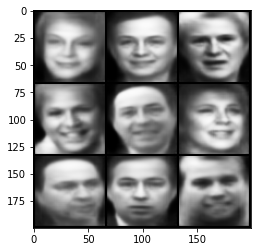

[Epoch 352] Training Loss: 479.959           | KL l.: 82.758 | Rec l.: 397.201
[Epoch 353] Training Loss: 479.964           | KL l.: 82.749 | Rec l.: 397.215
[Epoch 354] Training Loss: 480.226           | KL l.: 82.787 | Rec l.: 397.439
[Epoch 355] Training Loss: 480.078           | KL l.: 82.956 | Rec l.: 397.123
[Epoch 356] Training Loss: 479.804           | KL l.: 82.718 | Rec l.: 397.086
[Epoch 357] Training Loss: 479.807           | KL l.: 82.881 | Rec l.: 396.926
[Epoch 358] Training Loss: 479.373           | KL l.: 82.776 | Rec l.: 396.598
[Epoch 359] Training Loss: 479.462           | KL l.: 82.779 | Rec l.: 396.682
[Epoch 360] Training Loss: 479.327           | KL l.: 82.784 | Rec l.: 396.543
[Epoch 361] Training Loss: 479.400           | KL l.: 82.544 | Rec l.: 396.856
[Epoch 362] Training Loss: 479.473           | KL l.: 82.882 | Rec l.: 396.591
[Epoch 363] Training Loss: 479.300           | KL l.: 82.832 | Rec l.: 396.467
[Epoch 364] Training Loss: 478.961           | KL l.

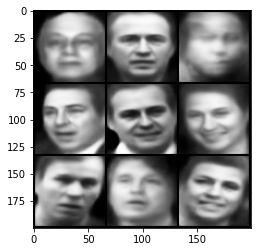

[Epoch 402] Training Loss: 477.542           | KL l.: 83.666 | Rec l.: 393.876
[Epoch 403] Training Loss: 477.481           | KL l.: 83.547 | Rec l.: 393.934
[Epoch 404] Training Loss: 477.299           | KL l.: 83.525 | Rec l.: 393.775
[Epoch 405] Training Loss: 477.515           | KL l.: 83.608 | Rec l.: 393.907
[Epoch 406] Training Loss: 477.267           | KL l.: 83.617 | Rec l.: 393.650
[Epoch 407] Training Loss: 476.937           | KL l.: 83.482 | Rec l.: 393.455
[Epoch 408] Training Loss: 477.148           | KL l.: 83.697 | Rec l.: 393.450
[Epoch 409] Training Loss: 477.358           | KL l.: 83.780 | Rec l.: 393.578
[Epoch 410] Training Loss: 477.130           | KL l.: 83.686 | Rec l.: 393.444
[Epoch 411] Training Loss: 476.984           | KL l.: 83.768 | Rec l.: 393.216
[Epoch 412] Training Loss: 477.182           | KL l.: 83.684 | Rec l.: 393.498
[Epoch 413] Training Loss: 477.024           | KL l.: 83.716 | Rec l.: 393.307
[Epoch 414] Training Loss: 476.986           | KL l.

In [9]:
model = Conv_VAE()
model.cuda()
optimizer = Adam(model.parameters(), lr=1e-4)

epochs = 450
beta_r = 0.5
beta_max = 4
beta_period = math.floor(len(train_dataloader) * beta_r)
beta_delta = beta_max / beta_period

for epoch in range(epochs):
    running_loss = 0.0
    running_kl_loss = 0.0
    running_reconstruction_loss = 0.0
    step = 0
    beta = 0
    
    for i, data in enumerate(train_dataloader, 0):
        optimizer.zero_grad()

        output, mean, logvar = model(data)
        
        kl_loss = ((-0.5) * torch.sum(1 + logvar - mean.pow(2) - torch.exp(logvar))) * beta / batch_size
        reconstruction_loss = nn.functional.l1_loss(output, data, reduction='sum') / batch_size
        loss = kl_loss + reconstruction_loss

        loss.backward()
        optimizer.step()
        
        step += 1
        running_loss += loss.item()
        running_kl_loss += kl_loss.item()
        running_reconstruction_loss += reconstruction_loss.item()
        
        if beta < beta_max:
            beta += beta_delta
            if beta >= beta_max:
                beta = beta_max
    print(f'[Epoch {epoch + 1}] Training Loss: {running_loss / step:.3f} \
          | KL l.: {running_kl_loss / step:.3f} | Rec l.: {running_reconstruction_loss / step:.3f}')

    if epoch % 50 == 0:
      model.eval()
    
      with torch.no_grad():
          latent_samples = torch.randn((9, latent_size)).cuda()
          images = model.generate(latent_samples).detach().cpu()
            
      grid = make_grid(images, nrow=3)
      plt.imshow(grid.permute(1, 2, 0))
      plt.show()

      model.train()
      

print('Finished Training')

## Model on test data

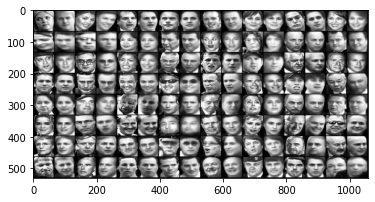

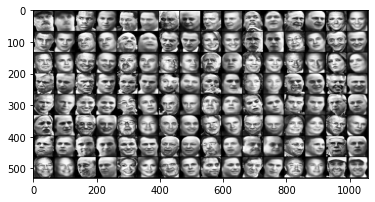

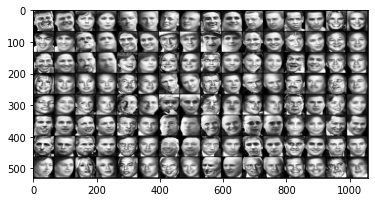

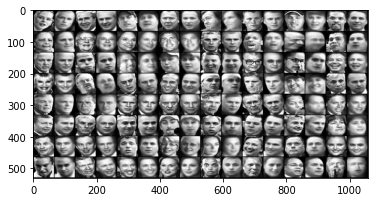

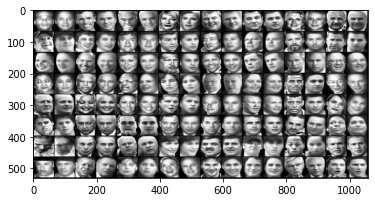

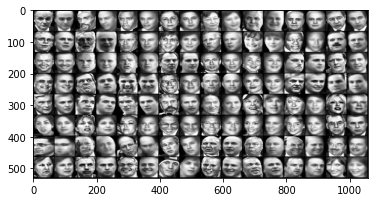

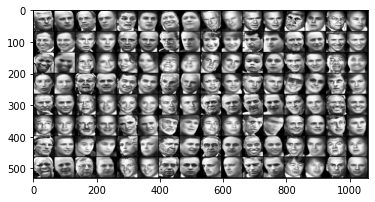

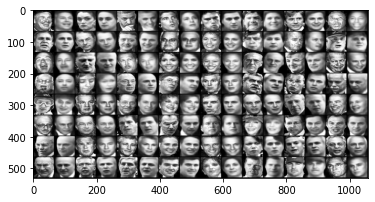

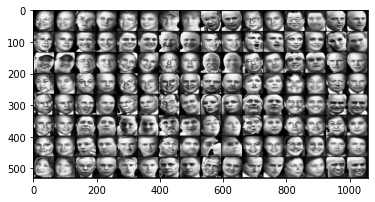

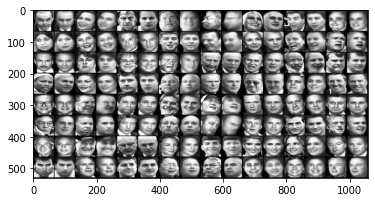

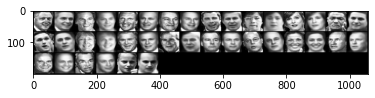

Test Loss: 415.069       | KL l.: 23.256915395910088 | Rec l.: 391.812


In [10]:
model.eval()
running_loss = 0.0
running_kl_loss = 0.0
running_reconstruction_loss = 0.0
for i, data in enumerate(test_dataloader, 0):
    with torch.no_grad():
        output, mean, logvar = model(data)
        
        kl_loss = ((-0.5) * torch.sum(1 + logvar - mean.pow(2) - torch.exp(logvar))) / batch_size
        reconstruction_loss = nn.functional.l1_loss(output, data, reduction='sum') / batch_size
        loss = kl_loss + reconstruction_loss
    running_loss += loss.item()
    running_kl_loss += kl_loss.item()
    running_reconstruction_loss += reconstruction_loss.item()
    images = torch.empty((output.shape[0]*2, 1, 64, 64), dtype=torch.float)
    images[0::2] = data.cpu()
    images[1::2] = output.cpu()
    grid = make_grid(images, nrow=16)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()
print(f'Test Loss: {running_loss / len(test_dataloader):.3f} \
      | KL l.: {running_kl_loss / len(test_dataloader)} | Rec l.: {running_reconstruction_loss / len(test_dataloader):.3f}')

## Model - generating images

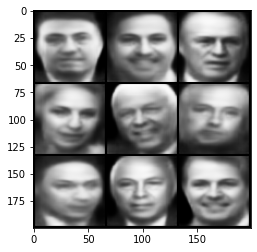

In [11]:
with torch.no_grad():
    latent_samples = torch.randn((9, latent_size)).cuda()
    images = model.generate(latent_samples).detach().cpu()
            
grid = make_grid(images, nrow=3)
plt.imshow(grid.permute(1, 2, 0))
plt.show()

## Test modelu - generowanie twarzy ze zbioru testowego od prowadzącego

In [ ]:
latent_samples = torch.Tensor([
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
latent_samples = latent_samples.float()

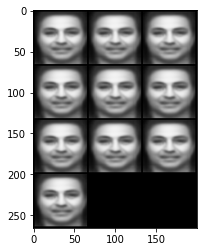

In [13]:
with torch.no_grad():
  latent_samples = latent_samples.cuda()
  images = model.generate(latent_samples).detach().cpu()
grid = make_grid(images, nrow=3)
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [14]:
plt.savefig("test_output.png")

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(images.shape[0]):
    image = images[i, ...]
    plt.imshow(image.permute(1,2,0), cmap='gray')
    plt.show()
    plt.savefig(f"output_separate{i}.png")